# Reproducible Code Supplement to "Approximating Nonlinear Forces with Phase-Space Decoupling"
## Produced in Affiliation with ESS and Lund University

## Prerequisites:

### Jupyter notebooks:
http://jupyter.readthedocs.io/en/latest/install.html
(note that the Anaconda package is the recommended starting point for a Python/SciPy/Jupyter environment)

### Julia:
http://julialang.org/downloads/platform.html

### First, open the Julia REPL from the desired working directory:
```bash
$ julia
  _       _ _(_)_     |  A fresh approach to technical computing
  (_)     | (_) (_)    |  Documentation: http://docs.julialang.org
   _ _   _| |_  __ _   |  Type "?help" for help.
  | | | | | | |/ _` |  |
  | | |_| | | | (_| |  |  Version 0.5.0-dev+2132 (2016-01-14 11:02 UTC)
 _/ |\__'_|_|_|\__'_|  |  Commit e2f8842* (244 days old master)
|__/                   |  x86_64-apple-darwin15.2.0


julia> 

```
Then run:
```julia
Pkg.add("IJulia")
Pkg.add("MultiPoly")
Pkg.add("PyCall")
Pkg.add("PyPlot")
Pkg.add("SymPy")
Pkg.add("Plots")
```
This may take several minutes, depending on your connection.

The Julia v0.4 kernel should now available in Jupyter. For troubleshooting, see:
https://github.com/JuliaLang/IJulia.jl

For interactivity, use the ".ipynb" version of this tutorial from this point.

In Julia REPL:
```julia
using IJulia
notebook()
```
or from the shell:
```bash
jupyter notebooks
```

In [86]:
using Plots,PyPlot,MultiPoly,PyCall,SymPy
default(palette = :viridis)
@pyimport numpy as np;
@pyimport numpy.random as npr;

In [87]:
function ∇Lie(f,g,r,o) # The rudimentary Lie Operator, i.e. the Poisson bracket
    diff(f,r)*diff(g,o)-diff(g,r)*diff(f,o)
end
#
function Lietrx(f,g,r,o,order=ord)  # Taylor series for exponential Lie Transform
    step = ∇Lie(f,g,r,o)
    result = g + step
    for i = 2:order+1
        step = ∇Lie(f,step,r,o)
        result = result + step/factorial(i)
    end    
    return(result)
end

Lietrx (generic function with 2 methods)

In [88]:
m = 1.        #Particle mass, normalized to 1 amu here
k = 1.E9      #Lab: [Teslas/meters^(n-1)] *longitudinal momentum [1 GeV / c] * fundamental charge [A*s]
#k_alt = 1E13 #CoM: [T/meters^(n-1)] * fundamental charge
L = 1E-4      #magnet thin-kick lengths
Ldr = 1E-3    #interspersed drifts

qᵥ, pᵥ = generators(MPoly{Float64}, :q, :p);   #MultiPoly variables for multiparticle calcs
xᵥ = Sym("x")                                  #SymPy varibles for envelope
mᵥ = Sym("m")

Hm = -L /m  * (k/4 * qᵥ^4+ 1/2 * pᵥ^2)           #Octupole hamiltonian (multiparticle)
#Hm_CM = -L * (k_alt/4 * pᵥ * qᵥ^4 + 1/2 * m * pᵥ^2 / 2) #CoM formalism, for reference only
Hdr =  -Ldr/2* pᵥ^2                          #Drift hamiltonian;

In [89]:
npr.seed(40002)                  
σq = .001        #StDv for position [meters]
σp = .001        #StDv for momentum [meters/second]
N = 10000          #Particle count
ord = 3          #Lie transform order of truncation
slc = 200        #number iterated kick--drift sections
mean, cov = [0,0], [(σq^2, 0), (0,σp^2)];

In [90]:
qₒ = Lietrx(Hm,qᵥ,:q,:p)      #output position/momentums for kick/drift sections, rspctv.
pₒ = Lietrx(Hm,pᵥ,:q,:p)
qₒD = Lietrx(Hdr,qᵥ,:q,:p)
pₒD = Lietrx(Hdr,pᵥ,:q,:p);
bGau = npr.multivariate_normal(mean, cov, N)   #Generic bigaussian generator;

In [91]:
#= Primary argument options:
               df = default multivariate expansion (no approximation in momentum)
               zr = null momentum in q expansion
               sg = naive dual-sigmas approximation  (Eqn. 5)
               er = "star" approximation (Eqn. 15)
=#
function multiter(f,slices=slc)        
    qₓ,pₓ = bGau[:,1], bGau[:,2]
    qₓ₂,pₓ₂ = bGau[:,1], bGau[:,2]    
    
    for j = 1:slc        
        
        if f == "df"       #kicks
            qₓ₃ = [MultiPoly.evaluate(qₒ,qₓ[i],pₓ[i]) for i = 1:length(qₓ)];
        else    
            qₓ₃ = [MultiPoly.evaluate(qₒ,qₓ[i],pₓ₂[i]) for i = 1:length(qₓ)];
        end
        pₓ₃ = [MultiPoly.evaluate(pₒ,qₓ[i],pₓ[i]) for i = 1:length(pₓ)];        
        
        #drifts    
        qₓ₃D = [MultiPoly.evaluate(qₒD,qₓ₃[i],pₓ₃[i]) for i = 1:length(qₓ)];
        pₓ₃D = [MultiPoly.evaluate(pₒD,qₓ₃[i],pₓ₃[i]) for i = 1:length(pₓ)];

        σq = np.std(qₓ₃D)   #Re-setting stdv values
        σp = np.std(pₓ₃D)    
            
        if f != "df"        
            for i =1:length(qₓ)
                if f == "zr"
                    pₓ₂[i] = 0
                elseif f == "sg"
                    pₓ₂[i] = -qₓ₃D[i]*σp/σq        
                elseif f == "er"
                    e_factq = erf(qₓ₃D[i]/(sqrt(2)*σq))/2
                    rhoq = exp(-qₓ₃D[i]^2/(2*σq^2))/sqrt(2*pi*σq^2)
                    pₓ₂[i] = -exp(-2*qₓ₃D[i]*rhoq/e_factq)*(qₓ₃D[i])*σp/σq
                end
             end
        end
         qₓ = copy(qₓ₃D)    
         pₓ = copy(pₓ₃D) 
    end
    return(qₓ,pₓ)
end

multiter (generic function with 2 methods)

In [92]:
qₓdf, pₓdf =multiter("df");
qₓzr, pₓzr =multiter("zr");
qₓsg, pₓsg =multiter("sg");
qₓer, pₓer =multiter("er");


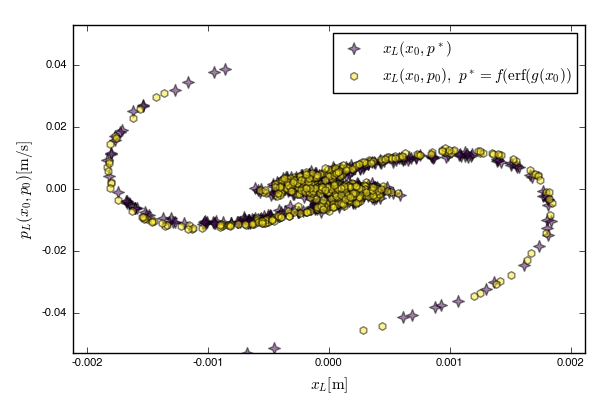

In [93]:
Plots.scatter(qₓdf[1:length(qₓdf)./500:end],pₓdf[1:length(pₓdf)./500:end],
alpha=.5,m=(:star4,8.5),grid=false, label = L"x_L(x_0,p^*)")
Plots.scatter!(qₓer[1:length(qₓer)./500:end], pₓer[1:length(pₓer)./500:end],alpha=.5,m=(:hexagon,5.5),
label = L"x_L(x_0,p_0), \ p^*=f(\mathrm{erf}(g(x_0))")

plot!(ylim=(-.05,.05))
plot!(xlim=(-.002,.002))

xlabel!(L"x_L\rm{[m]}")
ylabel!(L"p_L(x_0,p_0)\rm{[m/s]}")
#
plot!(margin=15px,top_margin=25px,bottom_margin=5px,
legendfont=Plots.font("Helvetica",11))
#png("/Users/$USER/Desktop/zeros")


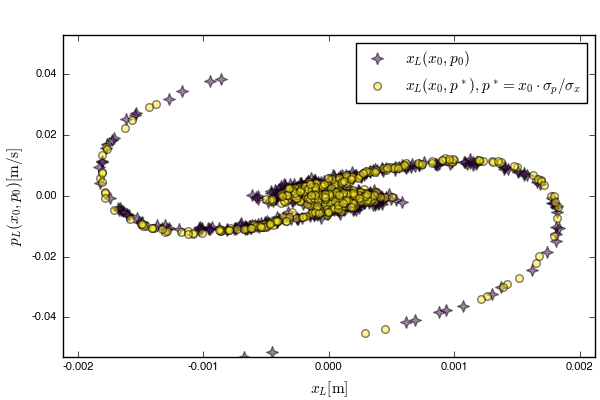

In [94]:
Plots.scatter(qₓdf[1:length(qₓdf)./500:end],pₓdf[1:length(pₓdf)./500:end],alpha=.5,
label = L"x_L(x_0,p_0)",m=(:star4,8.5))
Plots.scatter!(qₓsg[1:length(qₓsg)./500:end],pₓsg[1:length(pₓsg)./500:end],alpha=.5,m=(:circle,5.5),grid=false,
label = L"x_L(x_0,p^*), p^* = x_0\cdot\sigma_p/\sigma_x")

plot!(ylim=(-.05,.05))
plot!(xlim=(-.002,.002))
xlabel!(L"x_L\rm{[m]}")
ylabel!(L"p_L(x_0,p_0)\rm{[m/s]}")
#
plot!(margin=5px,top_margin=35px,bottom_margin=1px,
legendfont=Plots.font("Helvetica",11))
#png("/Users/$USER/Desktop/sigs")


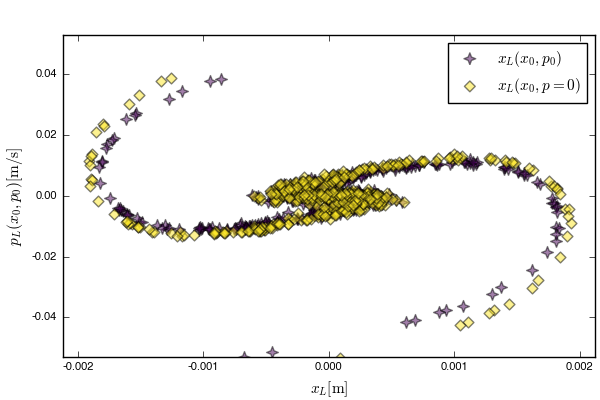

In [95]:
Plots.scatter(qₓdf[1:length(qₓdf)./500:end],pₓdf[1:length(pₓdf)./500:end],
alpha=.5,m=(:star4,8.5),grid=false,
label = L"x_L(x_0,p_0)")
Plots.scatter!(qₓzr[1:length(qₓzr)./500:end],pₓzr[1:length(pₓzr)./500:end],alpha=.5,
label = L"x_L(x_0,p=0)",m=(:diamond,5.5))

plot!(ylim=(-.05,.05))
plot!(xlim=(-.002,.002))

xlabel!(L"x_L\rm{[m]}")
ylabel!(L"p_L(x_0,p_0)\rm{[m/s]}")
#
plot!(margin=5px,top_margin=35px,bottom_margin=1px,
legendfont=Plots.font("Helvetica",11))
#png("/Users/$USER/Desktop/zeros")

# Envelope Tests
## (Sympy-based)

In [96]:
σₓ = 0.001  #stdv. for position and momentum
σm = 0.001  

ρ = 1/(sqrt(2*pi*σₓ^2))*exp(-(xᵥ^2)/(2*σₓ^2)) #gaussian distributions (monovariate)
ρm = 1/(sqrt(2*pi*σm^2))*exp(-(mᵥ^2)/(2*σm^2)) #gaussian distribution (monovariate)

χ = erf(xᵥ/(sqrt(2)*σₓ))/2                        
χm = erf(mᵥ/(sqrt(2)*σm))/2      

m_str = exp(-2*ρ*xᵥ/χ)*xᵥ*σm/σₓ; #Eqn. 17
x_str = exp(-2*ρm*mᵥ/χm)*mᵥ*σₓ/σm; #Eqn. 18

                                       2 
                            -500000.0*m  
       -1595.76912160573*m*e             
       ----------------------------------
            erf(707.106781186547*m)      
1.0*m*e                                  

In [97]:
k = 5.E9      #Lab: [Teslas/meters^(n-1)] *longitudinal momentum [1 GeV / c] * fundamental charge [A*s]
L = 1E-2      #magnet thin-kick lengths
Hm_s = -L/m * (k/4 * xᵥ^4+ 1/2 * mᵥ^2)         # Same as above, for envelope
xₒ = Lietrx(Hm_s,xᵥ,xᵥ,mᵥ)  #default outputs for envelope
mₒ = Lietrx(Hm_s,mᵥ,xᵥ,mᵥ);

xₒapr = xₒ(mᵥ=>m_str)  #outputs with approximations
#mₒapr = mₒ(xᵥ=>x_str)

xₓ,mₓ = bGau[:,1], bGau[:,2]
xₒλ = lambdify(xₒ)(xₓ,mₓ)     #lambdifying both outputs, momentum results not shown
xₒλapr = lambdify(xₒapr)(xₓ);

In [98]:
dxₒdx = diff(xₒ,xᵥ)
dmₒdp = diff(mₒ,mᵥ)
#dxₒdp = diff(xₒ,mᵥ)  
#dpₒdx = diff(mₒ,xᵥ)

Jcb = dxₒdx*dmₒdp #Nonzero element of 2D Jacobian
Jcb = (Jcb(mᵥ=>m_str))
Jcb = removeO(series(Jcb,xᵥ))   
Jcb_chk = dxₒdx(mᵥ=>m_str)
Jcb_chk = removeO(series(Jcb_chk,xᵥ))

ρₒ = ρ/abs(Jcb)   #Eqn. 23
ρₒchk = ρ/abs(Jcb_chk) #"Uncoupled" version;


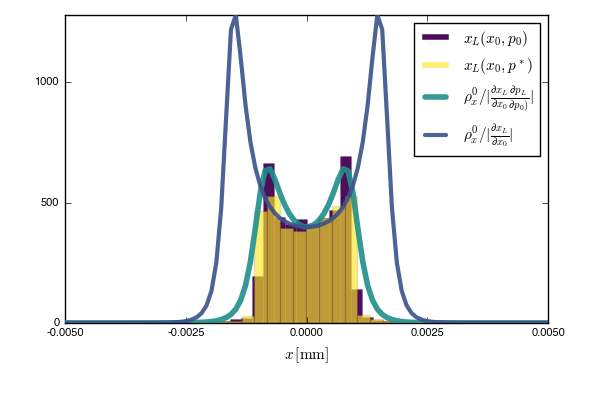

In [99]:
xr = .005 #x-range
bns = 150  #bins

histogram(xₒλ,alpha=0.95,bins=bns,line=0.1,normed=true,label=L"x_L(x_0,p_0)",)
histogram!(xₒλapr,alpha=.65,bins=bns,line=0.1,normed=true,label=L"x_L(x_0,p^*)")

plot!(ρₒ,-xr,xr,line=(.91,4), 
label=L"\rho^0_x /|\frac{\partial x_L}{\partial x_0}\frac{\partial p_L}{\partial p_0)}|")

plot!(ρₒchk,-xr,xr,line=(.91,3),
label=L"\rho^0_x / |\frac{\partial x_L}{\partial x_0}|")

plot!(margin=35px,top_margin=15px,xlabel=(L"x\/\rm{[mm]}"),legendfont=Plots.font("Helvetica",11))
plot!(xlim=(-xr,xr),grid=false)

#plot!(ylim=(0,1500))